In [ ]:
import os
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
import torch
from torch import Tensor
import torch_geometric
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid
import networkx as nx
from networkx.algorithms import community

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

In [ ]:
data_dir = "Data/"

In [ ]:
os.makedirs(data_dir, exist_ok=True)

In [ ]:
dataset = Planetoid(root=data_dir, name='Cora')

In [ ]:
dataset[0]

In [ ]:
data = dataset[0]

In [ ]:
data

In [ ]:
data.num_nodes

In [ ]:
data.num_edges

In [ ]:
print(f'Has isolated nodes: {data.has_isolated_nodes()}')  # False
print(f'Has self-loops: {data.has_self_loops()}')  # False
print(f'Is undirected: {data.is_undirected()}')  # True

In [ ]:
edge_index = data.edge_index.numpy()


In [ ]:
print(edge_index.shape)

In [ ]:
edge_example = edge_index[:, np.where(edge_index[0]==466)[0]]


In [ ]:
edge_example

In [ ]:
node_example = np.unique(edge_example.flatten())

In [ ]:
plt.figure(figsize=(10, 6))
G = nx.Graph()
G.add_nodes_from(node_example)
G.add_edges_from(list(zip(edge_example[0], edge_example[1])))
nx.draw_networkx(G, with_labels=True)

In [ ]:
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
# Average node degree: 3.90

In [ ]:
G = to_networkx(data, to_undirected=True)
degrees = [val for (node, val) in G.degree()]
display(pd.DataFrame(pd.Series(degrees).describe()).transpose().round(2))
print(len(degrees))
print(sum(degrees))
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=50)
plt.xlabel("node degree")
plt.show()

In [ ]:
print(f"Graph name: {G}")
print("Nodes:", G.nodes())
print("Edges:", G.edges())

In [ ]:
# Find the number of nodes and edges
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)

In [ ]:
G = to_networkx(data, to_undirected=True)
pos = nx.spring_layout(G, seed=42)
cent = nx.degree_centrality(G)
node_size = list(map(lambda x: x * 500, cent.values()))
cent_array = np.array(list(cent.values()))
threshold = sorted(cent_array, reverse=True)[10]
print("threshold", threshold)
cent_bin = np.where(cent_array >= threshold, 1, 0.1)
plt.figure(figsize=(12, 12))
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size,
#                                cmap=plt.cm.plasma,
                               node_color=cent_bin,
                               nodelist=list(cent.keys()),
                               alpha=cent_bin)
edges = nx.draw_networkx_edges(G, pos, width=0.25, alpha=0.3)
plt.show()

In [ ]:
# check training nodes
print("# of nodes to train on: ", data.train_mask.sum().item())

# check test nodes
print("# of nodes to test on: ", data.test_mask.sum().item())

# check validation nodes
print("# of nodes to validate on: ", data.val_mask.sum().item())

In [ ]:
print(f'Number of features: {data.num_node_features}')

In [ ]:
print(len(data.x[0]))
data.x[0][:20]

In [ ]:
print(f'Number of edge features: {data.num_edge_features}')
# Number of edge features: 0

In [ ]:
print(f'Number of classes: {dataset.num_classes}')
# Number of classes: 7

In [ ]:
dataset.num_classes

In [ ]:
label_dict = {
    0: "Theory",
    1: "Reinforcement_Learning",
    2: "Genetic_Algorithms",
    3: "Neural_Networks",
    4: "Probabilistic_Methods",
    5: "Case_Based",
    6: "Rule_Learning"}

In [ ]:
G

In [ ]:
data.y[:20]

In [ ]:
counter = collections.Counter(data.y.numpy())
counter = dict(counter)
print(counter)
count = [x[1] for x in sorted(counter.items())]
plt.figure(figsize=(10, 6))
plt.bar(range(7), count)
plt.xlabel("class", size=20)
plt.show()

In [ ]:
G = to_networkx(data, to_undirected=True)
node_color = []
nodelist = [[], [], [], [], [], [], []]
colorlist = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628']
labels = data.y
for n, i in enumerate(labels):
    node_color.append(colorlist[i])
    nodelist[i].append(n)
pos = nx.spring_layout(G, seed = 42)
plt.figure(figsize = (10, 10))
labellist = list(label_dict.values())
for num, i in enumerate(zip(nodelist, labellist)):
    n, l = i[0], i[1]
    nx.draw_networkx_nodes(G, pos, nodelist=n, node_size = 5, node_color = colorlist[num], label=l)
nx.draw_networkx_edges(G, pos, width = 0.25)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

In [ ]:
labels = data.y.numpy()
connected_labels_set = list(map(lambda x: labels[x], data.edge_index.numpy()))
connected_labels_set = np.array(connected_labels_set)
def add_missing_keys(counter, classes):
    for x in classes:
        if x not in counter.keys():
            counter[x] = 0
    return counter
label_connection_counts = []
for i in range(7):
    print(f"label: {i}")
    connected_labels = connected_labels_set[:, np.where(connected_labels_set[0] == i)[0]]
    print(connected_labels.shape[1], "edges")
    counter = collections.Counter(connected_labels[1])
    counter = dict(counter)
    print(counter)
    counter = add_missing_keys(counter, range(7))
    items = sorted(counter.items())
    items = [x[1] for x in items]
    label_connection_counts.append(items)
label_connection_counts = np.array(label_connection_counts)
plt.figure(figsize=(9, 7))
plt.rcParams["font.size"] = 13
hm = sns.heatmap(label_connection_counts, annot=True, cmap='hot_r', cbar=True, square=True)
plt.xlabel("class",size=20)
plt.ylabel("class",size=20)
plt.tight_layout()
plt.show()

In [ ]:
label_connection_counts.diagonal().sum() / label_connection_counts.sum()
# 0.8099658961727927

In [ ]:
def scaling(array):
    return array / sum(array)
label_connection_counts_scaled = np.apply_along_axis(scaling, 1, label_connection_counts)
plt.figure(figsize=(9, 7))
plt.rcParams["font.size"] = 13
hm = sns.heatmap(
    label_connection_counts_scaled,
    annot=True,
    cmap='hot_r',
    fmt="1.2f",
    cbar=True,
    square=True)
plt.xlabel("class",size=20)
plt.ylabel("class",size=20)
plt.tight_layout()
plt.show()

In [ ]:
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Number of validation nodes: {data.val_mask.sum()}')
print(f'Number of test nodes: {data.test_mask.sum()}')

In [ ]:
split_type_array = np.zeros(data.num_nodes)
split_type_array[np.where(data.train_mask == True)[0]] = 1
split_type_array[np.where(data.val_mask == True)[0]] = 2
split_type_array[np.where(data.test_mask == True)[0]] = 3
split_type_array
plt.scatter(range(2708), split_type_array)
plt.xlabel("index")
plt.show()

In [ ]:
titles = ["Training", "Validation", "Test"]
fig, axes = plt.subplots(ncols=3, figsize=(21, 6))
for i in range(3):
    counter = collections.Counter(data.y.numpy()[np.where(split_type_array == i + 1)[0]])
    counter = dict(counter)
    print(titles[i], counter)
    count = [x[1] for x in sorted(counter.items())]
# plt.figure(figsize=(10, 6))
    axes[i].bar(range(7), count)
    axes[i].set_xlabel("class", size=20)
    axes[i].set_title(titles[i])
plt.show()

In [1]:
import os
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
import torch
from torch import Tensor
import torch_geometric
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid
import networkx as nx
from networkx.algorithms import community

In [2]:
# Set random seed for reproducibility
import numpy as np

seed_value = 42
np.random.seed(seed_value)

In [4]:
# # Create a graph
G = nx.karate_club_graph()
# G = nx.Graph()
# G.add_edges_from([(1, 2), (1, 3), (2, 4), (2, 5), (3, 6), (4, 5), (5, 6)])

In [5]:
G

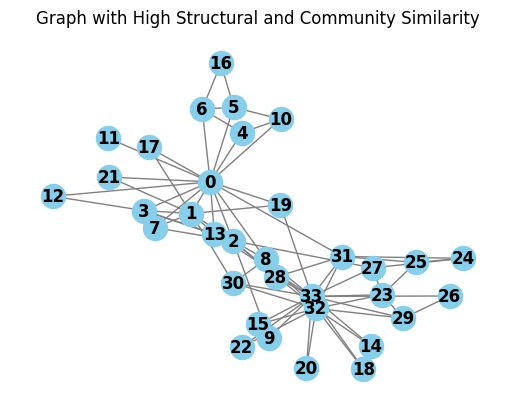

In [6]:
# Define node positions using a spring layout
import matplotlib.pyplot as plt
pos = nx.spring_layout(G, seed=42)

# Create a Matplotlib figure and axis
fig, ax = plt.subplots()

# Draw nodes and edges
nx.draw(G, pos, with_labels=True, node_size=300, node_color='skyblue', font_size=12, font_color='black', font_weight='bold', edge_color='gray', ax=ax)

# Add a title
ax.set_title('Graph with High Structural and Community Similarity')

# Show the plot
plt.axis('off')
plt.show()

In [7]:
from node2vec_def.node2vec import Node2Vec

In [8]:
import networkx as nx
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from hyperopt import fmin, tpe, hp
from scipy.optimize import minimize

In [14]:
# Define Node2Vec parameters
dimensions = 3
walk_length = 3
num_walks = 3
p = 4.0
q = 2.0
learning_rate = 0.01
window_size = 5
epochs = 20
negative_samples = 2

In [31]:
def objective_function(Z, S):
    """
    Calculate the objective function ||Z^T*Z - S||^2.

    Args:
        Z (numpy.ndarray): The node embeddings as a numpy array.
        S (numpy.ndarray): The similarity matrix.

    Returns:
        float: The value of the objective function.
    """
    Z_transpose = np.transpose(Z)
    diff = np.dot(Z_transpose, Z) - S
    obj_func = np.linalg.norm(diff) ** 2
    return obj_func

In [16]:
# import networkx as nx
# import numpy as np
# from scipy.optimize import minimize
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import random
# import matplotlib.pyplot as plt

In [17]:
# # Define your objective function
# def objective_function(params):
#     dimensions, walk_length, num_walks, p, q, learning_rate, window_size, epochs, negative_samples = params

#     # Create and train the Node2Vec model
#     node2vec_model = Node2Vec(G, int(dimensions), int(walk_length), int(num_walks), p, q, learning_rate, int(window_size), int(epochs), int(negative_samples))
#     node2vec_model.train()
#     S = node2vec_model.compute_similarity_matrix()

#     # Calculate the objective function value
#     embeddings = node2vec_model.get_embeddings()
#     Z_transpose = np.transpose(embeddings)
#     diff = np.dot(Z_transpose, embeddings) - S
#     obj_func = np.linalg.norm(diff) ** 2
#     return obj_func

In [18]:
model = Node2Vec(G, dimensions, walk_length, num_walks, p, q, learning_rate, window_size, epochs, negative_samples)


In [19]:
embeddings_bt = model.get_embeddings()


In [20]:
embeddings_bt

array([[-0.17969583, -0.39954722, -0.12632106,  0.11996083, -0.19816828,
        -0.00122153, -0.057229  ,  0.26668805,  0.25218278,  0.01959264,
         0.07071773,  0.34186432,  0.27775633,  0.2932274 , -0.04830053,
         0.07068326,  0.2240324 ,  0.37233055,  0.31076714, -0.01866694,
         0.2948184 , -0.0837524 , -0.00261463,  0.17161618, -0.37828186,
         0.12447036,  0.4014386 , -0.00051932,  0.3538147 , -0.21855201,
         0.38851273,  0.0199208 ,  0.25267968,  0.106223  ],
       [-0.18151523, -0.26630548, -0.05049817, -0.14764783, -0.38847172,
        -0.1751179 ,  0.06991907, -0.04126737,  0.22361764, -0.0825156 ,
         0.13186915,  0.36267692,  0.05400979, -0.03425828,  0.07874524,
         0.06073944,  0.24698174, -0.37548587, -0.39493752, -0.3967616 ,
        -0.10772234, -0.06491747, -0.2724668 ,  0.25199637,  0.33138818,
         0.21361992,  0.09652992,  0.33277816,  0.32477877,  0.13829373,
        -0.26225594, -0.20336461, -0.39451542,  0.22312425],
  


Epoch 1/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]

Epoch 2/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]

Epoch 3/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]

Epoch 4/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]

Epoch 5/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]

Epoch 6/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]

Epoch 7/20: 100%|████████████████████████████████████████

Epoch 18/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]

Epoch 19/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.07s/it]

Epoch 20/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]


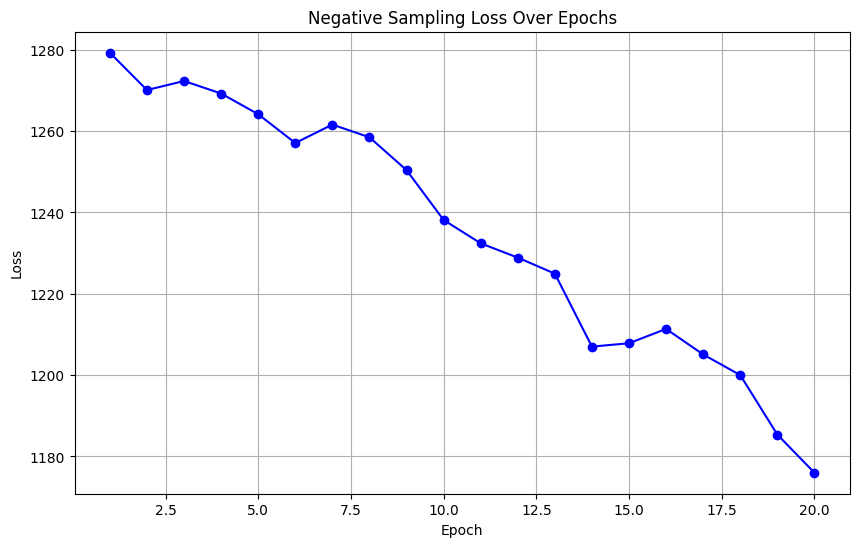

In [21]:
model.train()

In [22]:
embeddings = model.get_embeddings()

In [23]:
embeddings

array([[-0.90211993, -0.47016144, -0.17726122, -0.30466422, -0.68456763,
        -0.66279465, -0.75848985, -0.4189235 ,  0.4741018 ,  0.11930168,
        -0.6008562 , -0.32619336, -0.13908496, -0.07078983,  0.51887524,
         0.4504041 , -0.4913362 , -0.17396894,  0.7200754 , -0.1670662 ,
         0.6095417 , -0.5962195 ,  0.76228684,  0.32231095, -0.43162182,
        -0.11697823,  0.47828123, -0.16119987,  0.20694692,  0.36984184,
         0.5412948 , -0.01078044,  1.0088174 ,  1.0241014 ],
       [-0.7258076 , -0.94228405, -0.2669598 , -0.64308065, -0.4178974 ,
        -0.16911419, -0.14720602, -0.5920535 , -0.02316272, -0.01594575,
        -0.28591734, -0.11244863, -0.3532218 , -0.30843404,  0.22713237,
         0.23004688,  0.07003922, -0.7157927 , -0.09985785, -0.54111034,
         0.08710491, -0.42548212,  0.01176682,  0.79598826,  1.1661106 ,
         0.88626355,  0.29341528,  0.8397771 ,  0.47260788,  0.5385268 ,
        -0.31977478,  0.7969642 ,  0.21849564,  0.4202725 ],
  

In [24]:
# Get the node embeddings
Z =model.get_embeddings()

In [25]:
Z

array([[-0.90211993, -0.47016144, -0.17726122, -0.30466422, -0.68456763,
        -0.66279465, -0.75848985, -0.4189235 ,  0.4741018 ,  0.11930168,
        -0.6008562 , -0.32619336, -0.13908496, -0.07078983,  0.51887524,
         0.4504041 , -0.4913362 , -0.17396894,  0.7200754 , -0.1670662 ,
         0.6095417 , -0.5962195 ,  0.76228684,  0.32231095, -0.43162182,
        -0.11697823,  0.47828123, -0.16119987,  0.20694692,  0.36984184,
         0.5412948 , -0.01078044,  1.0088174 ,  1.0241014 ],
       [-0.7258076 , -0.94228405, -0.2669598 , -0.64308065, -0.4178974 ,
        -0.16911419, -0.14720602, -0.5920535 , -0.02316272, -0.01594575,
        -0.28591734, -0.11244863, -0.3532218 , -0.30843404,  0.22713237,
         0.23004688,  0.07003922, -0.7157927 , -0.09985785, -0.54111034,
         0.08710491, -0.42548212,  0.01176682,  0.79598826,  1.1661106 ,
         0.88626355,  0.29341528,  0.8397771 ,  0.47260788,  0.5385268 ,
        -0.31977478,  0.7969642 ,  0.21849564,  0.4202725 ],
  

In [26]:
Z.shape

(3, 34)

In [27]:
# Compute the similarity matrix
S = model.compute_similarity_matrix()

In [28]:
S.shape

(34, 34)

In [29]:
S

array([[1.        , 0.33333333, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.33333333, 1.        , 0.33333333, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.33333333, 1.        , ..., 0.        , 0.        ,
        0.66666667],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.33333333],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.33333333],
       [0.        , 0.        , 0.66666667, ..., 0.33333333, 0.33333333,
        1.        ]])

In [32]:
# 
# Calculate the objective function
obj_value = objective_function(Z, S)


In [33]:
print("Objective Function Value:", obj_value)

Objective Function Value: 193.78671621132764


In [47]:
initial_hyperparameters = {
    'dimensions': 2.0,
    'walk_length': 20.0,
    'num_walks': 20.0,
    'p': 0.5,
    'q': 0.5,
    'learning_rate': 0.1,
    'window_size': 5.0,
    'epochs': 20.0,
    'negative_samples': 10.0
}

In [48]:
# Initial guess for hyperparameters
initial_guess = list(initial_hyperparameters.values())

In [49]:
initial_guess

[2.0, 20.0, 20.0, 0.5, 0.5, 0.1, 5.0, 20.0, 10.0]

In [ ]:
# Minimize the objective function to find optimal hyperparameters
result = minimize(objective_function, initial_guess, method='Nelder-Mead', options={'disp': True})


Epoch 7/20:   0%|                                                                                                                   | 0/20 [00:00<?, ?it/s]

In [ ]:
# Extract the best hyperparameters
best_hyperparameters = dict(zip(initial_hyperparameters.keys(), result.x))


In [ ]:
# Print the best hyperparameters and the corresponding objective function value
print("Best Hyperparameters:", best_hyperparameters)
print("Objective Function Value:", result.fun)